#  <font color='dark gary'> Anomaly detection method
https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

### 1. Supervised learning

### 2. Semi-Supervised learning (Novelty detection)
- 새로운 한번도 보지 못한 데이터가 outlier인지 아닌지 판단(훈련데이터에 outlier가 없음)

### 3. Unsupervised learning (Outlier detection)
- inlier와 outlier를 포함한 훈련데이터에서 outliers를 탐색
        * Anomaly는 outlier와 novelty를 모두 호칭

- 응용 분야
     * Data cleaning
     * Fraud detection like credit card frauds or security breaches
     * Health monitoring of people, systems, and machines

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

### 불균형데이터 유형
- 이상치는 극히 심한 불균형데이터와 같은 유형을 갖는다.
- make_classification() 함수에 클라스를 무작위로 교환하여 분류를 어렵게 함, flip_y=0

Counter({0: 990, 1: 10})

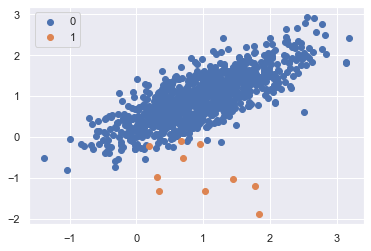

In [2]:
from collections import Counter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

Counter(y)

for label, _ in Counter(y).items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()

# 1. Supervised Learning

In [3]:
import pandas as pd
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### 1.1 Interquartile Range(IQR) - Box plot으로 outlier 탐색
단일 변수의 백분위수 (range)를 확인하여 이상치(outlier)를 그려보고 확인한다

<AxesSubplot:>

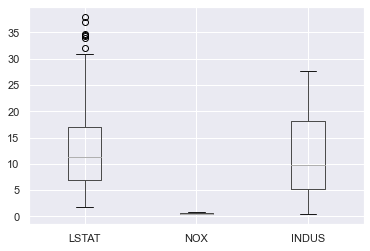

In [4]:
cols = ['LSTAT','NOX','INDUS']
boston.boxplot(column=cols)

### 1.2 확률밀도함수로 이상치 확인

단일변수의 확률밀도 함수를 확인하여 이상치를 p-value로 확인한다

In [5]:
import scipy as sp
sp.stats.norm(loc=0, scale=1) # 평균0, 표준편차 1
rv = sp.stats.norm(loc=0, scale=1)
(1- rv.pdf(1.96), 1- rv.pdf(2.58))

(0.9415590556665485, 0.9856948910058503)

가우시안 분포를 가정하여 pdf(probability density distribution)이 임계치를 넘으면 이상치라고 판단

array([[<AxesSubplot:title={'center':'LSTAT'}>,
        <AxesSubplot:title={'center':'NOX'}>],
       [<AxesSubplot:title={'center':'INDUS'}>, <AxesSubplot:>]],
      dtype=object)

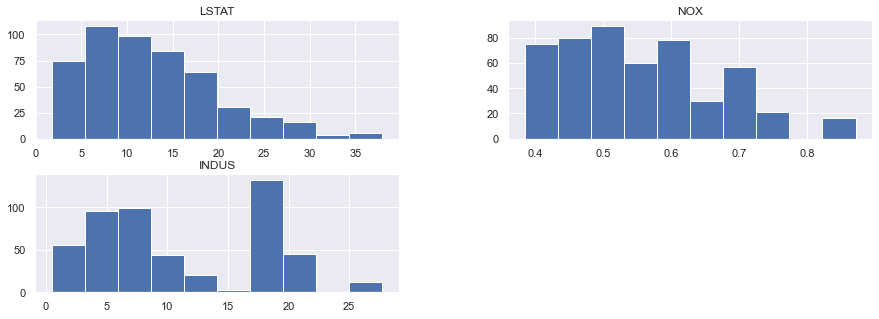

In [6]:
data = boston[cols]
data.hist(figsize=(15,5))

In [7]:
data['LSTAT'] = (data['LSTAT'] -data['LSTAT'].mean())/data['LSTAT'].std()
data['LSTAT_pdf'] = rv.pdf(data['LSTAT'])
data[(data['LSTAT_pdf'] < 0.01) | (data['LSTAT_pdf'] > 0.99)]

,LSTAT,NOX,INDUS,LSTAT_pdf
141,3.046737,0.624,21.89,0.003848
373,3.097150,0.668,18.10,0.003296
374,3.545262,0.668,18.10,0.000744
412,3.041136,0.597,18.10,0.003914
414,3.406628,0.693,18.10,0.001205
438,2.992123,0.740,18.10,0.004538


#  2. Semi-Supervised learning (Novelty detection)
## One-class SVM with non-linear kernel (RBF)
- OCSVM assumes that anomalies can form dense clusters as long as they form a low-density region in the training dataset.
- OCSVM mode is trained in only one class, referred to as the normal class. The model learns all the features and patterns of the normal class 
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

#### <p> <font color= 'blue'> Intuition : One-class SVM is based on SVM, which uses a hyperplane to seperate two classes while a  <b>One-class SVM uses a hypersphere to emcompass all of the observations<b> <p>

# 예제1
예측한 y값이 1은 정상(inlier)을, -1은 이상치(outlier)

In [8]:
from sklearn.svm import OneClassSVM
X = [[0], [0.44], [0.45], [0.46], [1]]
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)

array([-1,  1,  1,  1, -1], dtype=int64)

In [9]:
clf.decision_function(X)

array([-2.74925564e-01,  5.28455635e-09,  8.06251090e-04,  1.35696904e-03,
       -3.21513634e-01])

In [10]:
clf.score_samples(X)

array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])

# 예제 2
- https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#one-class-svm-with-non-linear-kernel-rbf

In [11]:
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.font_manager

# 생성 된 그리드 포인트의 수평 및 수직 좌표 행렬 초기화
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

### 1. 훈련데이터 생성(outliers가 없음, 모두 정상 데이터)
### Generate train data(X_train)

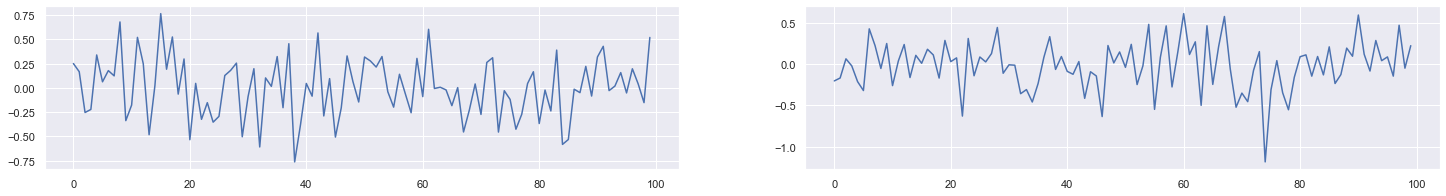

In [12]:
X = 0.3 * np.random.randn(100, 2)
plt.rcParams["figure.figsize"] = (25,3)
fig, ax = plt.subplots(ncols=2) # 1 row by 2 columns
ax[0].plot(X[:, 0])
ax[1].plot(X[:, 1])

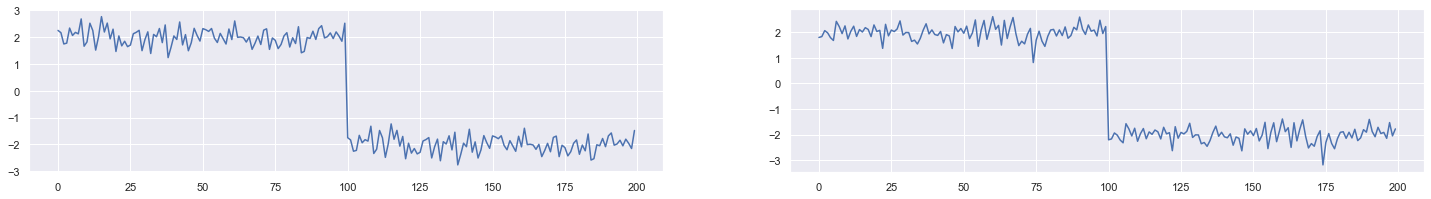

In [13]:
X_train = np.r_[X + 2, X - 2]
fig, ax = plt.subplots(ncols=2) # 1 row by 2 columns
ax[0].plot(X_train[:, 0])
ax[1].plot(X_train[:, 1])

In [14]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X).predict(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

### '-1'은 이상치로 x1, x2가 둘중에 하나가 과도하게 이상하면 '-1'판정(다변량분석)

<BarContainer object of 100 artists>

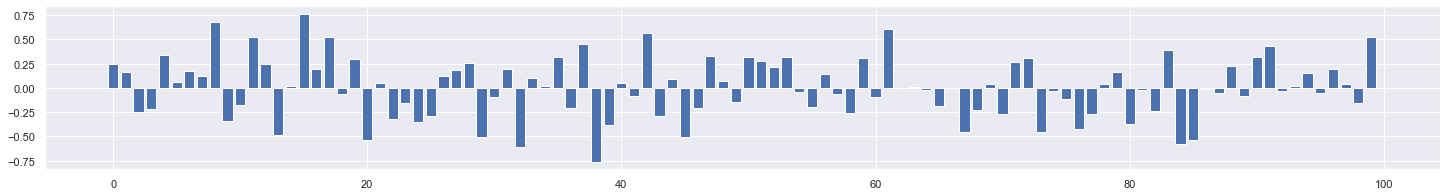

<BarContainer object of 100 artists>

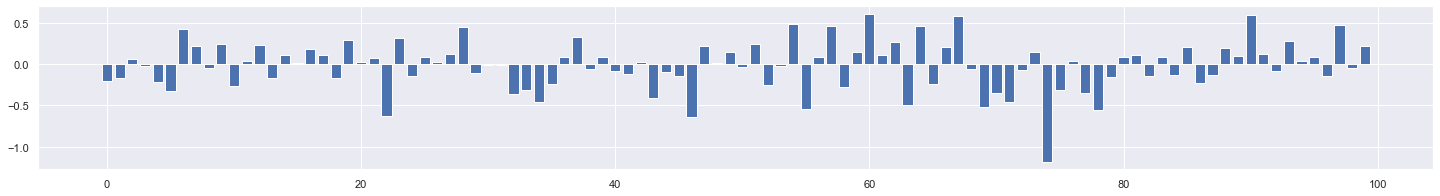

In [15]:
plt.bar(np.arange(len(X[:, 0])),X[:, 0]);plt.show()
plt.bar(np.arange(len(X[:, 1])),X[:, 1])

### 단변량의 이상치 탐색 결과와는 틀리다

In [16]:
clf.fit(X).predict(X)
clf.fit(X[:,0].reshape(-1,1)).predict(X[:,0].reshape(-1,1))
clf.fit(X[:,1].reshape(-1,1)).predict(X[:,1].reshape(-1,1))

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1],
      dtype=int64)

### X로 학습하여 X_train을 이상치 탐색하면 모두 '1' 로 이상치로 판정

In [17]:
clf.fit(X).predict(X_train)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

### 2. 새로운 정상데이터(X_test)와 비정상데이터(X_outliers) 생성
### Generate some regular novel observations(X_test)

In [18]:
X = 0.3 * np.random.randn(20, 2)  
X_test = np.r_[X + 2, X - 2] 

### Generate some abnormal novel observations(X_outliers)

In [19]:
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

### 새로운 정상데이터(X_test)와 비정상데이터(X_outliers) 그래프

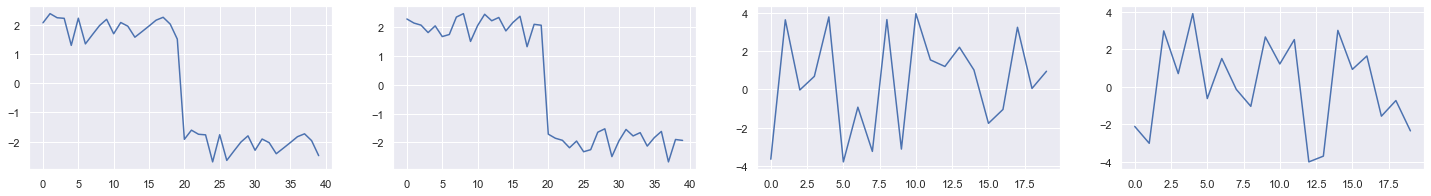

In [20]:
fig, ax = plt.subplots(ncols=4) # 1 row by 4 columns
ax[0].plot(X_test[:, 0])
ax[1].plot(X_test[:, 1])
ax[2].plot(X_outliers[:, 0])
ax[3].plot(X_outliers[:, 1])

#### 3. 정상데이터 학습 (fit the model to X_train)
- 주로 kernel로 RBF사용 
- One Class SVM는 이상치가 없는 정상적인 훈련데이터를 학습하여 새로운 데이터를 분류(이진분류)
        * nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
          Should be in the interval (0, 1]. By default 0.5 will be taken. (margin error와 관계있음)
        * 파라미터 nu가 0.5라는 것은 훈련데이터의 misclassification error는 최대 5%라는 것이고 margin error는 최소 5%라는 
          (즉, 최소한 lower bound 마진에러를 감수하고 최대한 분류에러의 upper bound 확보)

In [21]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(gamma=0.1, nu=0.1)

#### 4. 예측
- OneClassSVM으로 각각의 데이터를 이진분류 예측 판단한 labeled y를 구한다

In [22]:
y_pred_train = clf.predict(X_train)
y_pred_train

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int64)

In [23]:
y_pred_test = clf.predict(X_test)
y_pred_test
y_pred_outliers = clf.predict(X_outliers)
y_pred_outliers

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1], dtype=int64)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1], dtype=int64)

### y_pred_test는 새로운 데이터로 정상이 많은 데이터오 이상치 '-1'이 가끔 있다고 예측
### y_pred_outliers는 모두 비정상 --> 예측값이 '1'이면 error임,

In [24]:
n_error_train = y_pred_train[y_pred_train == -1].size
print(f'X_train({len(X_train)})에서 오류 개수는 {n_error_train}, 오류확률 {n_error_train/len(X_train)*100} %')
n_error_test = y_pred_test[y_pred_test == -1].size
print(f'X_test({len(X_test)})에서 오류 개수는 {n_error_test}, 오류확률 {n_error_test/len(X_test)*100} %')
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
print(f'X_outliers({len(X_outliers)})에서 오류 개수는 {n_error_outliers}, 오류확률 {n_error_outliers/len(X_outliers)*100} %')

X_train(200)에서 오류 개수는 20, 오류확률 10.0 %
X_test(40)에서 오류 개수는 5, 오류확률 12.5 %
X_outliers(20)에서 오류 개수는 0, 오류확률 0.0 %


Text(0.5, 1.0, 'Novelty Detection')

(-5.0, 5.0, -5.0, 5.0)

(-5.0, 5.0)

(-5.0, 5.0)

Text(0.5, 0, 'error train: 20/200 ; errors novel regular: 5/40 ; errors novel abnormal: 0/40')

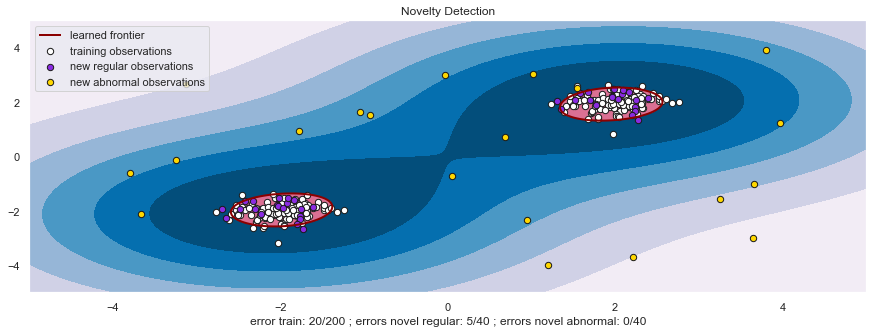

In [25]:
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(15,5))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

### <font color='red'> 실습 A. One-class SVM(breast cancer)

- UCI사이트에서 attribution information copy

In [26]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/'
df = pd.read_csv(url + 'breast-cancer-wisconsin.data')
df.columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
      'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
      'Normal Nucleoli', 'Mitoses', 'Class'] # (2 for benign, 4 for malignant)
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [27]:
df['Class'].value_counts(normalize=True)

2    0.654728
4    0.345272
Name: Class, dtype: float64

In [28]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [29]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?', 0)
df.loc[df['Class'] ==4, 'normal'] = -1  # -1  4 for malignant
df.loc[df['Class'] ==2, 'normal'] = 1 # 1 for benign
df.shape
df.head(2)

(698, 12)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,normal
0,1002945,5,4,4,5,7,10,3,2,1,2,1.0
1,1015425,3,1,1,1,2,2,3,1,1,2,1.0


In [30]:
train_rec_count=int(len(df)*.8)
df_train= df.iloc[:train_rec_count,:]
df_train.shape
df_train.head(2)
df_train['Class'].value_counts(normalize=True)

(558, 12)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,normal
0,1002945,5,4,4,5,7,10,3,2,1,2,1.0
1,1015425,3,1,1,1,2,2,3,1,1,2,1.0


2    0.630824
4    0.369176
Name: Class, dtype: float64

In [31]:
df_test=df.iloc[train_rec_count:,:]
df_test.shape
df_test.head(2)
df_test['Class'].value_counts(normalize=True)

(140, 12)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,normal
558,1321931,5,1,1,1,2,1,2,1,1,2,1.0
559,1321942,5,1,1,1,2,1,3,1,1,2,1.0


2    0.75
4    0.25
Name: Class, dtype: float64

In [32]:
X_train= df_train.iloc[:, 1:10]
y_train= df_train.iloc[:, 11]
X_test=df_test.iloc[:, 1:10]

### Creating the One-Class Support Vector Macine

In [33]:
normal_rec_count=len(df_train.loc[df_train['Class']==2])
nu_percentage= (train_rec_count - normal_rec_count)/train_rec_count
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')


ocsvm = OneClassSVM(nu=nu_percentage)

부적합율(훈련데이터:X_train)은 36.91756272401434 %


### Fitting the training data and predicting the results for the test data

In [34]:
ocsvm.fit(X_train, y_train)
yhat=ocsvm.predict(X_test)

OneClassSVM(nu=0.36917562724014336)

In [35]:
ocsvm.fit(X_train)

OneClassSVM(nu=0.36917562724014336)

In [36]:
df_test['onesvm_anomaly']= yhat
df_test

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,normal,onesvm_anomaly
558,1321931,5,1,1,1,2,1,2,1,1,2,1.0,1
559,1321942,5,1,1,1,2,1,3,1,1,2,1.0,1
560,1321942,5,1,1,1,2,1,3,1,1,2,1.0,1
561,1328331,1,1,1,1,2,1,3,1,1,2,1.0,1
562,1328755,3,1,1,1,2,1,2,1,1,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,776715,3,1,1,1,3,2,1,1,1,2,1.0,1
694,841769,2,1,1,1,2,1,1,1,1,2,1.0,1
695,888820,5,10,10,3,7,3,8,10,2,4,-1.0,-1
696,897471,4,8,6,4,3,4,10,6,1,4,-1.0,-1


<AxesSubplot:>

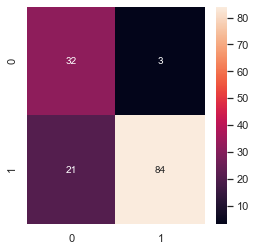

In [37]:
cm=confusion_matrix(df_test['normal'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot=True)

In [38]:
from sklearn.metrics import classification_report
target_names = ['Normal(1)', 'Abnormal(-1)']
print(classification_report(df_test['normal'], df_test['onesvm_anomaly'], target_names=target_names))

              precision    recall  f1-score   support

   Normal(1)       0.60      0.91      0.73        35
Abnormal(-1)       0.97      0.80      0.88       105

    accuracy                           0.83       140
   macro avg       0.78      0.86      0.80       140
weighted avg       0.88      0.83      0.84       140



In [39]:
print(" Accuracy Score for One-Class SVM :", accuracy_score(df_test['normal'], df_test['onesvm_anomaly']))
print(" Precision for One-Class SVM :", precision_score(df_test['normal'], df_test['onesvm_anomaly']))
print(" Recall for One-Class SVM :", recall_score(df_test['normal'], df_test['onesvm_anomaly']))
print(" Confusion Matrix: \n", cm)

 Accuracy Score for One-Class SVM : 0.8285714285714286
 Precision for One-Class SVM : 0.9655172413793104
 Recall for One-Class SVM : 0.8
 Confusion Matrix: 
 [[32  3]
 [21 84]]


# 3. Unsupervised learning (Outlier detection)
- inlier와 outlier를 포함한 훈련데이터에서 outliers를 탐색
        * Anomaly는 outlier와 novelty를 모두 호칭

# 3.1 Elliptic Envelop Algorithm
- 입력변수의 공분산이 가능한 고차원 데이터를 가우스 분포를 가정하여 모델링하기위한 supervised and unsupervised 알고리즘
        * (가우시안 분포를 갖는 자료를 가정하여 타원형 경계 외부에 있는 자료를 이상치로 판정)
- sklearn의 EllipticEnvelope API를 이용한 이상치 예측(An object for detecting outliers in a Gaussian distributed dataset)
        
### <p> <font color= 'blue'> Intuition : We draw an ellipse around the data points based on some criteria and classify any data point inside the ellipse as inliers and any observation outside the ellipse as an outlier.
        * 자료의 크기는 입력변수의 제곱보다 큰 경우에 적용(고차원 데이터)
    
- The scikit-learn provides an object covariance.EllipticEnvelope that fits a robust covariance estimate to the data, and thus fits an ellipse to the central data points, ignoring points outside the central mode.

In [40]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
true_cov = np.array([[.8, .3],
                     [.3, .4]])
X = np.random.RandomState(0).multivariate_normal(mean=[0, 0],
                                                 cov=true_cov,
                                                 size=500)
X[0:10]

array([[-1.61673103, -0.64316019],
       [-1.36314858,  0.51416492],
       [-1.38812887, -1.28529507],
       [-0.78603416, -0.50467625],
       [-0.0056125 ,  0.22487922],
       [-0.46025371,  0.5608042 ],
       [-0.6857151 , -0.29945373],
       [-0.4605907 , -0.06131079],
       [-1.24368003, -0.77946057],
       [-0.073319  , -0.51326387]])

### 1. Novelty detection(EllipticEnvelope())
- 평균(0,0)은 '1'로 정상자료로, 이상치(3,3)은 '-1'로 이상치로 판단

In [41]:
cov = EllipticEnvelope(random_state=0).fit(X)

# predict returns 1 for an inlier and -1 for an outlier
cov.predict([[0, 0],
             [3, 3]])

array([ 1, -1])

### 2. Outlier detection(EllipticEnvelope)

In [42]:
cov.predict(X)[0:10]
cov.covariance_
cov.location_

array([ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1])

array([[0.74118335, 0.25357049],
       [0.25357049, 0.30531502]])

array([0.0813539 , 0.04279722])

### <font color='red'> 실습 B. Multivariate gaussian distribution
- 두 독립변수의 분포는 정규분포이고 negative(y=0) 데이터가 800개, positive(y=1) 데이터 200개 
         * 첫번째 모집단 평균과 공분산
\begin{vmatrix}
-2 \\
-2
\end{vmatrix}
\begin{vmatrix}
1.0 & 0.9 & \\
0.9 & 2
\end{vmatrix}
    
          * 두번째 모집단 평균과 공분산
\begin{vmatrix}
+2 \\
+2
\end{vmatrix}
\begin{vmatrix}
1.2 & -0.5 & \\
-0.5 & 2
\end{vmatrix}

Text(0.5, 1.0, 'Multivariates pdf')

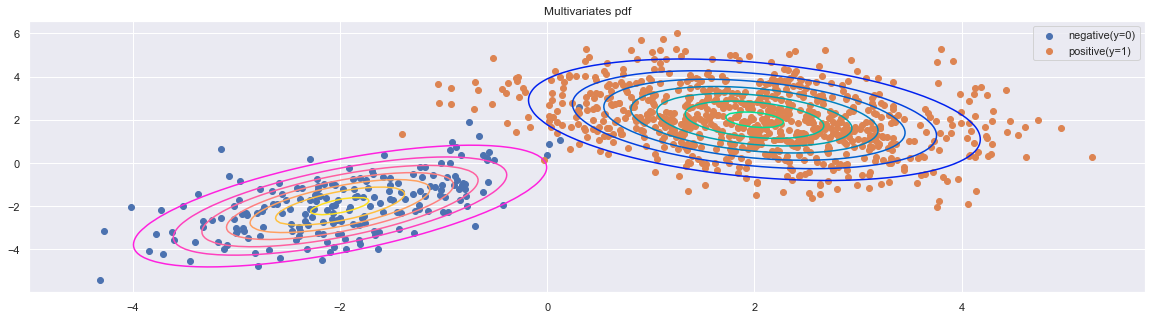

In [43]:
import scipy.stats as stats
np.random.seed(13)

rv0 = stats.multivariate_normal([-2, -2], [[1, 0.9], [0.9, 2]])
rv1 = stats.multivariate_normal([2, 2], [[1.2, -0.5], [-0.5, 2]])
x0 = rv0.rvs(200); x1 = rv1.rvs(800) # it is a fitting! ()

xx1 = np.linspace(-5, 5, 100); xx2 = np.linspace(-5, 5, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)

fig = plt.figure(figsize=(20,5))
plt.contour(xx1, xx2, rv0.pdf(np.dstack([xx1, xx2])), cmap='spring')
plt.contour(xx1, xx2, rv1.pdf(np.dstack([xx1, xx2])), cmap='winter')
plt.scatter(x0[:, 0], x0[:, 1], label='negative(y=0)')
plt.scatter(x1[:, 0], x1[:, 1], label='positive(y=1)')
plt.legend(); plt.title("Multivariates pdf")

plt.show()

# 3.2 Mahalanobis distance
For instance, assuming that the inlier data are Gaussian distributed, it will estimate the inlier location and covariance in a robust way (i.e. without being influenced by outliers). The Mahalanobis distances obtained from this estimate is used to derive a measure of outlyingness. This strategy is illustrated below.
- https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html
- https://www.youtube.com/watch?v=spNpfmWZBmg
- https://www.youtube.com/watch?v=xXhLvheEF7o
- The mahalanobis distance is a distance measure between a point and a distribution. It takes into account the correlation between the variables.

Text(0.5, 1.0, 'Multivariates pdf')

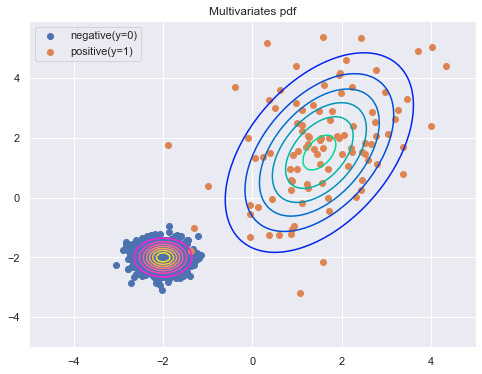

In [44]:
np.random.seed(11)

rv0 = stats.multivariate_normal([-2, -2], [[0.1, 0], [0, 0.1]])
rv1 = stats.multivariate_normal([1.5, 1.5], [[1.2, 0.8], [0.9, 3]])
x0 = rv0.rvs(800); x1 = rv1.rvs(100) # it is a fitting! ()

xx1 = np.linspace(-5, 5, 100); xx2 = np.linspace(-5, 5, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)

fig = plt.figure(figsize=(8,6))
plt.contour(xx1, xx2, rv0.pdf(np.dstack([xx1, xx2])), cmap='spring')
plt.contour(xx1, xx2, rv1.pdf(np.dstack([xx1, xx2])), cmap='winter')
plt.scatter(x0[:, 0], x0[:, 1], label='negative(y=0)')
plt.scatter(x1[:, 0], x1[:, 1], label='positive(y=1)')
plt.legend(); plt.title("Multivariates pdf")

plt.show()

In [45]:
# for consistent results
np.random.seed(7)

n_samples = 125
n_outliers = 25
n_features = 2

# generate Gaussian data of shape (125, 2)
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

In [46]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)

# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print('Estimated covariance matrix:\n'
      'MCD (Robust):\n{}\n'
      'MLE:\n{}'.format(robust_cov.covariance_, emp_cov.covariance_))

Estimated covariance matrix:
MCD (Robust):
[[ 3.26253567e+00 -3.06695631e-03]
 [-3.06695631e-03  1.22747343e+00]]
MLE:
[[ 3.23773583 -0.24640578]
 [-0.24640578  7.51963999]]


(-4.561265785217095, 10.0)

Text(0.5, 1.0, 'Mahalanobis distances of a contaminated data set')

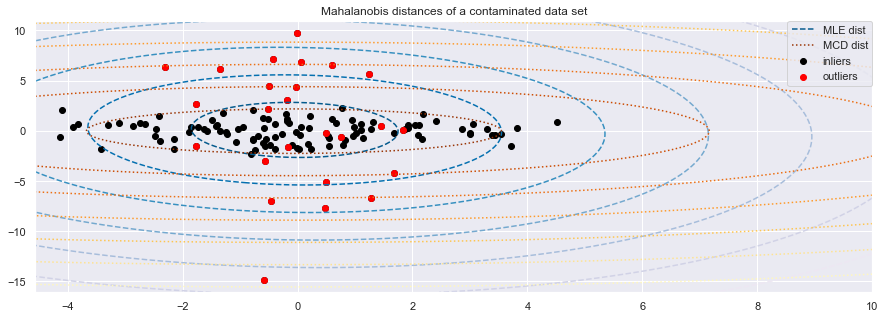

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1],
                         color='black', label='inliers')
outlier_plot = ax.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                          color='red', label='outliers')
ax.set_xlim(ax.get_xlim()[0], 10.)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r, linestyles='dashed')
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(xx, yy, np.sqrt(mahal_robust_cov),
                            cmap=plt.cm.YlOrBr_r, linestyles='dotted')

# Add legend
ax.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
          inlier_plot, outlier_plot],
          ['MLE dist', 'MCD dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)

plt.show()

To better visualize the difference, we plot contours of the Mahalanobis distances calculated by both methods. Notice that the robust MCD based Mahalanobis distances fit the inlier black points much better, whereas the MLE based distances are more influenced by the outlier red points.

### <font color='red'> 실습 B. Anomaly Detection using Gaussian Distribution
- Credit card fraud methods have become increasingly sophisticated with use of latest technology today by criminals. It is not a simple task anymore to identify outliers/Anamolous transactions before hand unless reported by the customer
- Lets get the dataframe for the Credit card transation data 
    
https://www.kaggle.com/mlg-ulb/creditcardfraud (Data obtain)

In [48]:
%time df = pd.read_csv('../data/creditcard.csv')
df = df[['V1', 'V2', 'V3', 'V4', 'V5', 'Class']]
df = df.sample(frac=0.1)
df.head()

Wall time: 5.37 s


,V1,V2,V3,V4,V5,Class
210133,-1.244489,0.108489,0.973635,1.134152,0.528911,0
246364,1.937771,-0.616874,-0.386245,0.352387,-0.742611,0
257436,-0.676848,0.188221,1.093049,-2.320219,0.253972,0
92075,-0.546760,-3.648723,0.052244,-0.322335,-2.435134,0
174068,-0.592921,0.413011,0.196688,-0.211114,2.704736,0


In [49]:
X = df.drop(['Class'], axis=1)
cov = EllipticEnvelope(random_state=0).fit(X)
cov

EllipticEnvelope(random_state=0)

In [50]:
df['Ell'] = cov.predict(X)
df.loc[df['Ell'] == 1, 'Ell'] = 0
df.loc[df['Ell'] == -1, 'Ell'] = 1

In [51]:
df[df['Class'] == df['Ell']].head()
df[df['Class'] != df['Ell']].head()

,V1,V2,V3,V4,V5,Class,Ell
210133,-1.244489,0.108489,0.973635,1.134152,0.528911,0,0
246364,1.937771,-0.616874,-0.386245,0.352387,-0.742611,0,0
257436,-0.676848,0.188221,1.093049,-2.320219,0.253972,0,0
174068,-0.592921,0.413011,0.196688,-0.211114,2.704736,0,0
71475,0.278376,0.790074,0.388767,0.252324,0.426031,0,0


,V1,V2,V3,V4,V5,Class,Ell
92075,-0.546760,-3.648723,0.052244,-0.322335,-2.435134,0,1
238581,-0.860896,-0.585676,-4.136853,-0.154461,-0.120164,0,1
65445,-2.737817,0.426440,0.694096,1.535532,-1.407678,0,1
189389,0.574843,-2.701386,-2.478355,0.463651,0.312697,0,1
279072,-3.341723,-0.733000,0.363989,-1.187261,-0.238747,0,1


In [52]:
df[df['Class'] != df['Ell']].Class.value_counts()

0    2807
1       3
Name: Class, dtype: int64

# 3.3 Isolation Forest algorithm
- outlier는 희귀할 것이다. 즉 instances의 개수도 적을 뿐만아니라 일반 데이터의 속성값과는 다른 값을 가지고 있을 것이다라는 가정에서 출발
       * (tree-based algorithm으로 high-dimension 자료에서 anomaly(outlier, novelty) detection에 효과적)
       * (Random forests 알고리즘을 사용하면 효과적)

### <p> <font color= 'blue'> Intuition : tree구조로 단지 몇 번의 가지치기를 통해 outlier를 isolate시킬 수 있지만 정상자료는 아주 여러번의 가기치기를 하여야 함

https://dodonam.tistory.com/129

In [53]:
from sklearn.ensemble import IsolationForest
X = np.array([[-1, -1], [-2, -1], [-3, -2], [0, 0], [-20, 50], [3, 5]])
X
clf = IsolationForest(n_estimators=10, warm_start=True)

clf.fit(X)  # fit 10 trees  

array([[ -1,  -1],
       [ -2,  -1],
       [ -3,  -2],
       [  0,   0],
       [-20,  50],
       [  3,   5]])

IsolationForest(n_estimators=10, warm_start=True)

The ensemble.IsolationForest supports warm_start=True which allows you to add more trees to an already fitted model:

In [54]:
clf.set_params(n_estimators=20)  # add 10 more trees  

clf.fit(X)  # fit the added trees  

IsolationForest(n_estimators=20, warm_start=True)

IsolationForest(n_estimators=20, warm_start=True)

In [55]:
clf.predict(X)

array([ 1,  1,  1,  1, -1, -1])

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
- The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
- Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.
- This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.
- Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

가지치기는 변수를 무작위로 threshold도 무작위로 마구 해본다

In [56]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]

# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

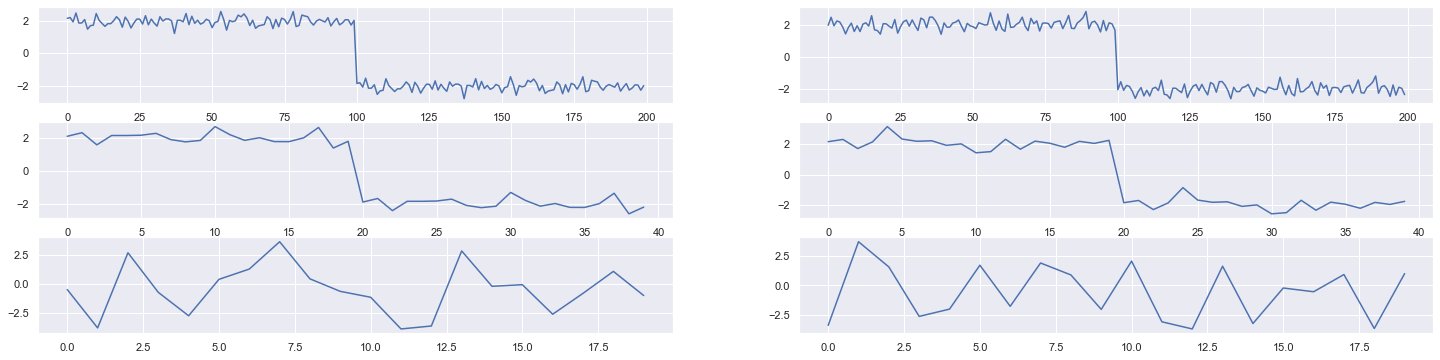

In [57]:
plt.rcParams["figure.figsize"] = (25,6)
fig, ax = plt.subplots(nrows=3, ncols=2) # 1 row by 4 columns
ax[0][0].plot(X_train[:, 0])
ax[0][1].plot(X_train[:, 1])
ax[1][0].plot(X_test[:, 0])
ax[1][1].plot(X_test[:, 1])
ax[2][0].plot(X_outliers[:, 0])
ax[2][1].plot(X_outliers[:, 1])

IsolationForest(max_samples=100,
                random_state=RandomState(MT19937) at 0x1BD0F284440)

Text(0.5, 1.0, 'IsolationForest')

(-5.0, 5.0, -5.0, 5.0)

(-5.0, 5.0)

(-5.0, 5.0)

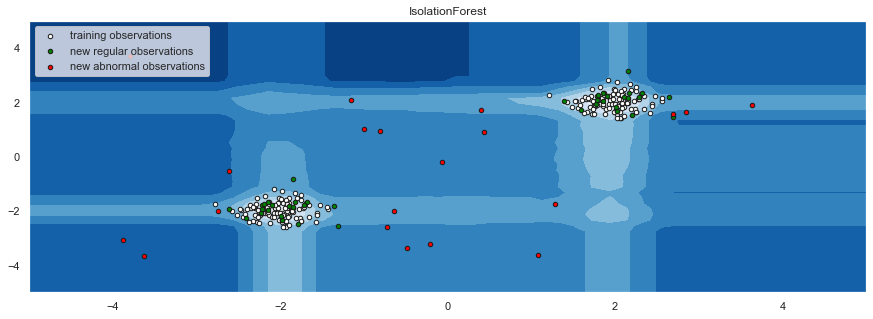

In [58]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(15,5))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

### <font color='red'> 실습 C. Isolation Forest (boston data)

In [59]:
data = boston[cols]
data

,LSTAT,NOX,INDUS
0,4.98,0.538,2.31
1,9.14,0.469,7.07
2,4.03,0.469,7.07
3,2.94,0.458,2.18
4,5.33,0.458,2.18
...,...,...,...
501,9.67,0.573,11.93
502,9.08,0.573,11.93
503,5.64,0.573,11.93
504,6.48,0.573,11.93


In [60]:
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(boston['LSTAT'].values.reshape(-1,1))

IsolationForest()

In [61]:
anomaly_score = isolation_forest.decision_function(boston['LSTAT'].values.reshape(-1,1))
outlier = isolation_forest.predict(boston['LSTAT'].values.reshape(-1,1))
outlier

array([ 1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1, -1,  1

IsolationForest()

Text(0.5, 1.0, 'LSTAT')

IsolationForest()

Text(0.5, 1.0, 'NOX')

IsolationForest()

Text(0.5, 1.0, 'INDUS')

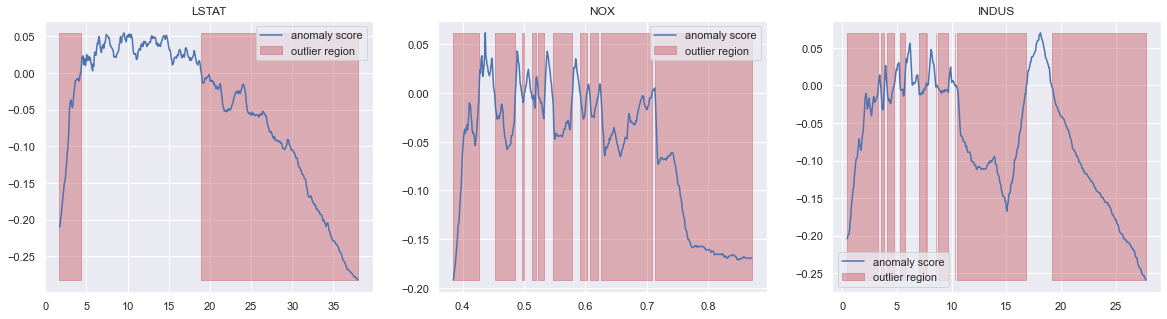

In [62]:
#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(boston[column].values.reshape(-1,1))

    xx = np.linspace(boston[column].min(), boston[column].max(), len(boston)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

# 3. 4 Local Outlier Factor : outlier and novelty detection (hyperparameter to True)
- 밀도(density)기반 Clustering알고리즘을 바탕으로 특정 데이터 주변의 Local density로 novelty 점수를 산정한다.

### <p> <font color= 'blue'> Intuition : We draw an ellipse around the data points based on some criteria and classify any data point inside the ellipse as inliers and any observation outside the ellipse as an outlier.

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html

## 1. Outlier detection
- lof=LocalOutlierFactor()
- lof.fit(X_train)
- lof.predict(X_train)

In [63]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

NearestNeighbors(n_neighbors=1)

In [64]:
print(neigh.kneighbors([[1., 1., 1.]]))

(array([[0.5]]), array([[2]], dtype=int64))


This means that the element is at distance 0.5 and is the third element of samples (indexes start at 0)

## 2 Novelty detection
To use neighbors.LocalOutlierFactor for novelty detection, i.e. predict labels or compute the score of abnormality of new unseen data, you need to instantiate the estimator with the novelty parameter set to True before fitting the estimator: 
- lof=LocalOutlierFactor(novelty=True)
- lof.fit(X_train)
- lof.predict(X_new)

In [65]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
X = [[-1.1], [0.2], [101.1], [0.3]]
clf = LocalOutlierFactor(n_neighbors=2)
clf.fit_predict(X)

clf.negative_outlier_factor_

array([ 1,  1, -1,  1])

array([ -0.98214286,  -1.03703704, -73.36970899,  -0.98214286])

# Summary

- Theimplementation of all techniques is quite similar except for LOF where the differencebetween outlier detection and novelty detection comes into play. 
- The Isolation Forest and LOF work well on high-dimensional data. For the purpose of visualization, we can apply the Principal Component Analysis to reduce thedimensionality of high-dimensional data.
- The Elliptic Envelope should only be used with data that satisfy the assumption ofnormality.
   * The most important hyperparameter in the Elliptic Envelope, Isolation Forest and LOF is the contamination hyperparameter. It represents the proportion of outliers in thedataset. In most cases, we do not know the exact value for the contamination hyperparameter. 
   * The best way to guess the value is that first do IQR-based detectionand count the number of outliers in the dataset.As you know the total of observations, you can get anapproximate value for the proportion of outliers. This is the value for the contamination hyperparameter!
- The One-class SVM is not very good for outlier detection, but the best option fornovelty detection when the training data is not much polluted with outliers. 

# End